In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
pip install numpy==1.26.4

  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.1
    Uninstalling numpy-2.0.1:
      Successfully uninstalled numpy-2.0.1
Note: you may need to restart the kernel to use updated packages.


  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: Could not install packages due to an OSError: [WinError 5] Access is denied: 'C:\\Users\\ibrah\\AppData\\Local\\Programs\\Python\\Python39\\Lib\\site-packages\\~-mpy.libs\\libscipy_openblas64_-fb1711452d4d8cee9f276fd1449ee5c7.dll'
Consider using the `--user` option or check the permissions.

You should consider upgrading via the 'c:\Users\ibrah\AppData\Local\Programs\Python\Python39\python.exe -m pip install --upgrade pip' command.


In [6]:
import numpy as np
print(np.__version__)


1.26.4


In [2]:


class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, kernel_size=4, stride=2, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

diffusion_model = UNet()


In [3]:
def generate_local_block(diffusion_model, noise_dim=(1, 1, 64, 64)):
    noise = torch.randn(noise_dim)
    local_block = diffusion_model(noise)
    return local_block

local_block = generate_local_block(diffusion_model)


In [4]:
class InpaintingNet(nn.Module):
    def __init__(self):
        super(InpaintingNet, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.network(x)

inpainting_net = InpaintingNet()

def inpaint(local_block, inpainting_net):
    refined_block = inpainting_net(local_block)
    return refined_block

refined_block = inpaint(local_block, inpainting_net)


In [5]:
class OutpaintingNet(nn.Module):
    def __init__(self):
        super(OutpaintingNet, self).__init__()
        self.network = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 1, kernel_size=3, padding=1),
            nn.Tanh(),
        )

    def forward(self, x):
        return self.network(x)

outpainting_net = OutpaintingNet()

def outpaint(refined_block, outpainting_net):
    extended_field = outpainting_net(refined_block)
    return extended_field

extended_field = outpaint(refined_block, outpainting_net)


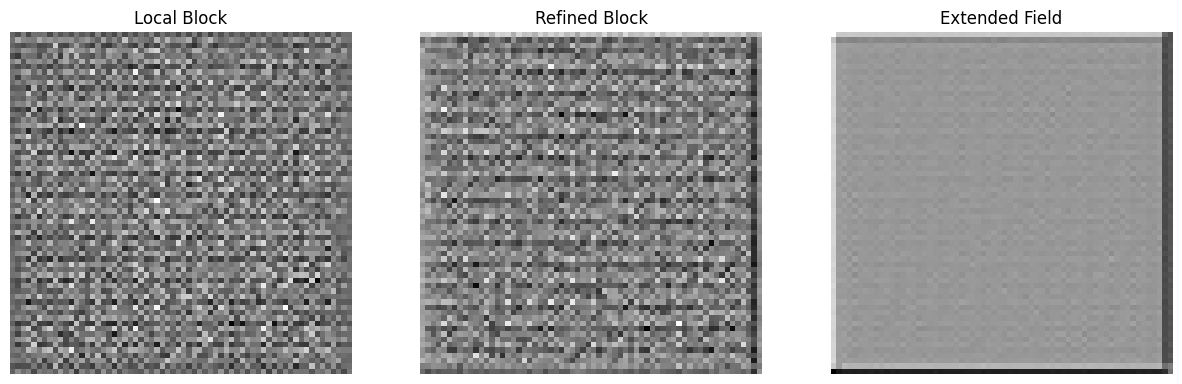

In [7]:
import matplotlib.pyplot as plt

# Initialize models
diffusion_model = UNet()
inpainting_net = InpaintingNet()
outpainting_net = OutpaintingNet()

# Define noise dimensions
noise_dim = (1, 1, 64, 64)  # (batch_size, channels, height, width)

# Generate local block using the diffusion model
local_block = generate_local_block(diffusion_model, noise_dim)

# Refine the local block using the inpainting network
refined_block = inpaint(local_block, inpainting_net)

# Extend the refined block using the outpainting network
extended_field = outpaint(refined_block, outpainting_net)

# Plot the generated images
def plot_image(tensor, title):
    image = tensor.detach().cpu().numpy().squeeze()
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plot_image(local_block, "Local Block")

plt.subplot(1, 3, 2)
plot_image(refined_block, "Refined Block")

plt.subplot(1, 3, 3)
plot_image(extended_field, "Extended Field")

plt.show()
